# 比较安庆市与合肥市的污染物时间序列是否存在一定的`相关关系`
# If there is any `correlation` between pollutants in Anqing and Hefei

---

*@author: Evan*
*@date: 2023-04-19*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
from findpoint import findpoint
import ModelEvaLib as me
import calc_statis as cs

## 读取数据

In [3]:
chemfile = xr.open_dataset('F:/Data/case_anqing/compressed_chem.nc')

O3 = chemfile.O3
NO2 = chemfile.NO2
com = O3 + NO2

lat = chemfile.latitude
lon = chemfile.longitude

In [4]:
sites = pd.read_excel('../obsdata/sites.xlsx',usecols=[2,3,4,5],index_col=1)
sitename = sites.index


lono = sites['经度']
lato = sites['纬度']

xls1 = pd.read_excel('../obsdata/O3.xlsx',index_col=0)
xls2 = pd.read_excel('../obsdata/NO2.xlsx',index_col=0)
xls1 = xls1.interpolate(axis=0,method='linear')
xls2 = xls2.interpolate(axis=0,method='linear')
obsO3 = xls1.loc[O3.time.values]
obsNO2 = xls2.loc[NO2.time.values]

df=obsO3+obsNO2

## 比较模拟数据

In [5]:
x_index = []
y_index = []
hefei   = np.arange(0,11)
anqing  = [11,12,14,15]

for i in range(len(lono[hefei])): 
    out_x, out_y = findpoint(lono[hefei][i],lato[hefei][i],O3)
    x_index.append(out_x)
    y_index.append(out_y)
nrO3_hf  = O3.isel(x=x_index, y=y_index)
nrNO2_hf = NO2.isel(x=x_index, y=y_index)
nrcom_hf = com.isel(x=x_index, y=y_index)

for i in range(len(lono[anqing])): 
    out_x, out_y = findpoint(lono[anqing][i],lato[anqing][i],O3)
    x_index.append(out_x)
    y_index.append(out_y)
nrO3_aq  = O3.isel(x=x_index, y=y_index)
nrNO2_aq = NO2.isel(x=x_index, y=y_index)
nrcom_aq = com.isel(x=x_index, y=y_index)

In [6]:
# 取对角线数据
diagO3_aq  = np.diagonal(nrO3_aq[:,0,:,:], axis1=1, axis2=2)
diagNO2_aq = np.diagonal(nrNO2_aq[:,0,:,:], axis1=1, axis2=2)
diagcom_aq = np.diagonal(nrcom_aq[:,0,:,:], axis1=1, axis2=2)

diagO3_hf  = np.diagonal(nrO3_hf[:,0,:,:], axis1=1, axis2=2)
diagNO2_hf = np.diagonal(nrNO2_hf[:,0,:,:], axis1=1, axis2=2)
diagcom_hf = np.diagonal(nrcom_hf[:,0,:,:], axis1=1, axis2=2)

# 计算平均值
simO3_aq  = np.mean(diagO3_aq,1)
simNO2_aq = np.mean(diagNO2_aq,1)
simcom_aq = np.mean(diagcom_aq,1)

simO3_hf  = np.mean(diagO3_hf,1)
simNO2_hf = np.mean(diagNO2_hf,1)
simcom_hf = np.mean(diagcom_hf,1)

In [7]:
me_aq= cs.calculate_statistics(simO3_aq,simNO2_aq)
me_hf= cs.calculate_statistics(simO3_hf,simNO2_hf)
me_O3= cs.calculate_statistics(simO3_aq,simO3_hf)
me_NO2= cs.calculate_statistics(simNO2_aq,simNO2_hf)
me_com= cs.calculate_statistics(simcom_aq,simcom_hf)

print(cs.calculate_statistics(simO3_aq,simNO2_aq))
print(cs.calculate_statistics(simO3_hf,simNO2_hf))
print(cs.calculate_statistics(simO3_aq,simO3_hf))
print(cs.calculate_statistics(simNO2_aq,simNO2_hf))
print(cs.calculate_statistics(simcom_aq,simcom_hf))

     R         ME       RMSE   IOA    NMB    NME
0 -0.4 -32.360001  42.900002  0.24 -61.73  81.84
      R         ME       RMSE   IOA    NMB    NME
0 -0.42 -33.619999  44.799999  0.25 -63.62  84.78
      R    ME  RMSE   IOA   NMB   NME
0  0.97  0.84  4.63  0.98  4.35  24.1
      R    ME  RMSE   IOA   NMB   NME
0  0.97 -0.42  4.34  0.98 -0.79  8.21
      R    ME  RMSE   IOA   NMB   NME
0  0.98  0.42  3.96  0.99  0.58  5.49


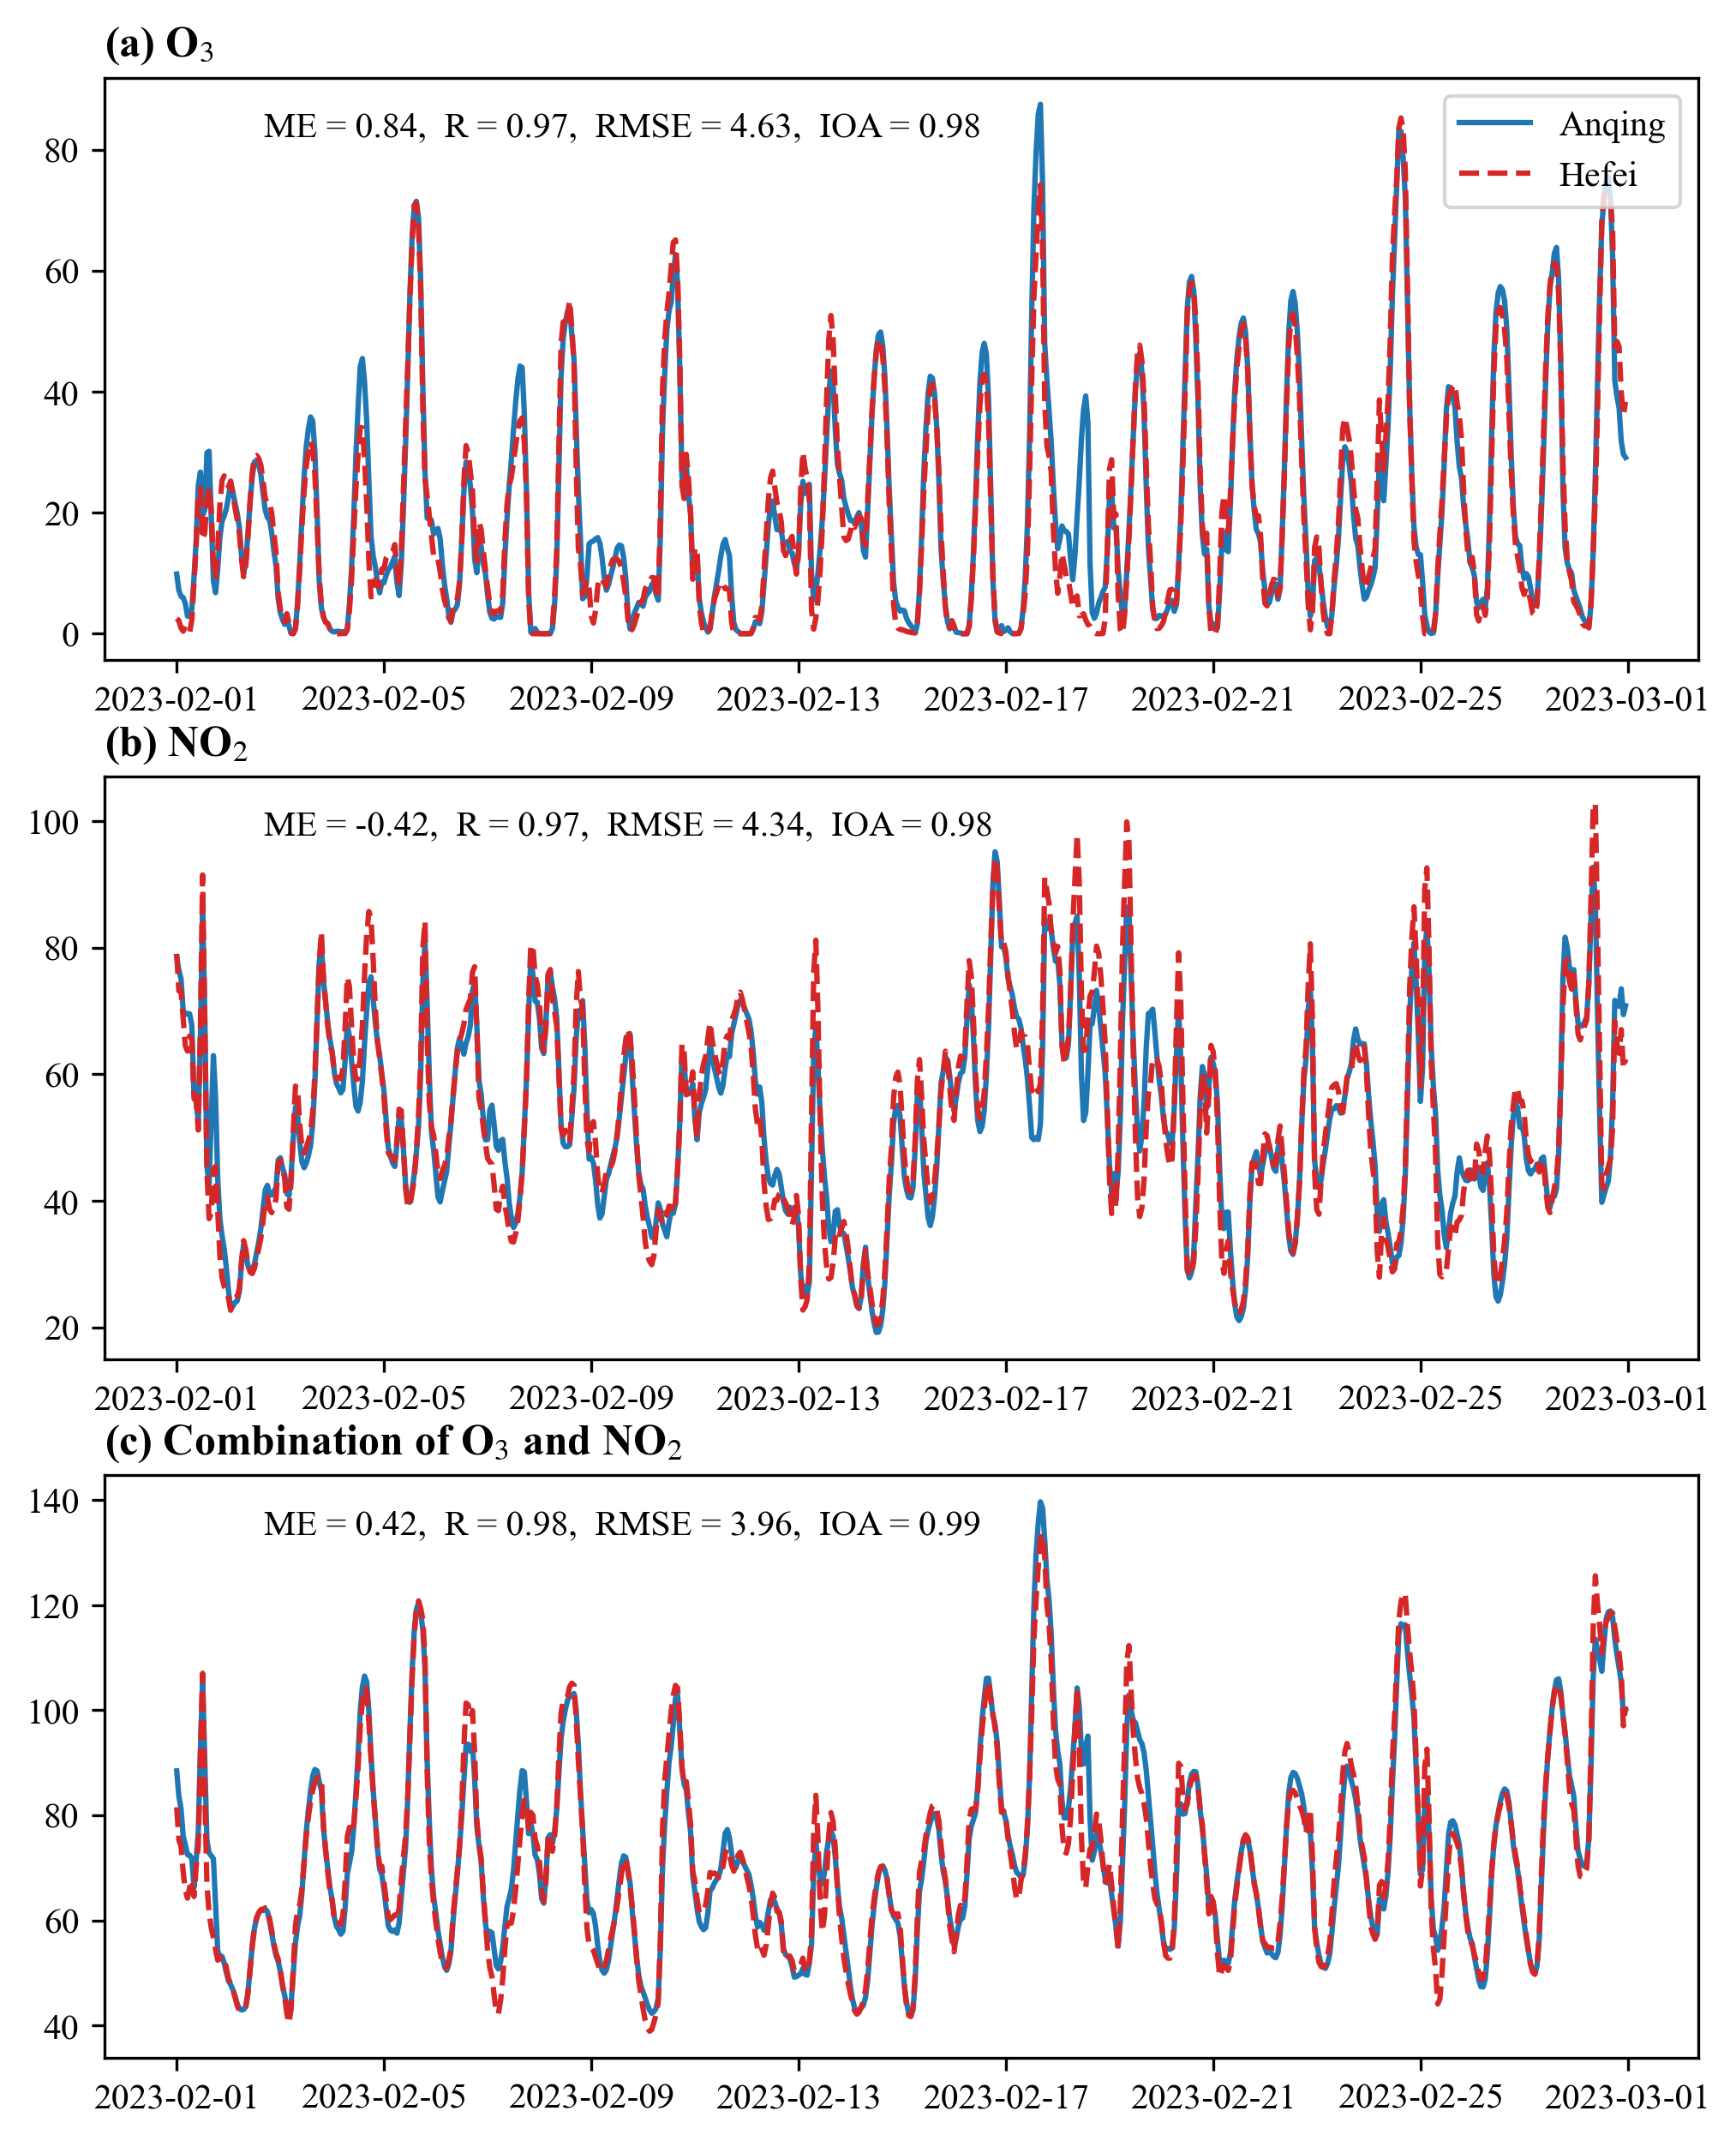

In [8]:
fig = plt.figure(figsize=(8,10),dpi=300)
ax  = fig.subplots(3,1)

time = pd.date_range('2023-02-01',periods=672,freq='H')

key_aq = {'linestyle':'-','label':'Anqing','color':'tab:blue'}
key_hf = {'linestyle':'--','label':'Hefei','color':'tab:red'}
ax[0].plot(time,simO3_aq,**key_aq)
ax[0].plot(time,simO3_hf,**key_hf)
evalstr = str('ME = '+str(me_O3['ME'].values[0])+',  '
              +'R = '+str(me_O3['R'].values[0])+',  '
              +'RMSE = '+str(me_O3['RMSE'].values[0])+',  '
              +'IOA = '+str(me_O3['IOA'].values[0]))
ax[0].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[0].transAxes)

ax[1].plot(time,simNO2_aq,**key_aq)
ax[1].plot(time,simNO2_hf,**key_hf)
evalstr = str('ME = '+str(me_NO2['ME'].values[0])+',  '
              +'R = '+str(me_NO2['R'].values[0])+',  '
              +'RMSE = '+str(me_NO2['RMSE'].values[0])+',  '
              +'IOA = '+str(me_NO2['IOA'].values[0]))
ax[1].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[1].transAxes)

ax[2].plot(time,simcom_aq,**key_aq)
ax[2].plot(time,simcom_hf,**key_hf)
evalstr = str('ME = '+str(me_com['ME'].values[0])+',  '
              +'R = '+str(me_com['R'].values[0])+',  '
              +'RMSE = '+str(me_com['RMSE'].values[0])+',  '
              +'IOA = '+str(me_com['IOA'].values[0]))
ax[2].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[2].transAxes)

ax[0].legend(loc=1)
ax[0].set_title('(a) O$_3$',loc='left',weight='bold')
ax[1].set_title('(b) NO$_2$',loc='left',weight='bold')
ax[2].set_title('(c) Combination of O$_3$ and NO$_2$',loc='left',weight='bold')

plt.show()


## 比较观测数据

In [9]:
hefei     = np.arange(0,11)
anqing    = [11,12,14,15]
obsO3_aq  = obsO3[anqing].mean(axis=1)
obsNO2_aq = obsNO2[anqing].mean(axis=1)
obsO3_hf  = obsO3[hefei].mean(axis=1)
obsNO2_hf = obsNO2[hefei].mean(axis=1)
obscom_aq = obsO3_aq + obsNO2_aq
obscom_hf = obsO3_hf + obsNO2_hf

In [10]:
me_aq= cs.calculate_statistics(obsO3_aq,obsNO2_aq)
me_hf= cs.calculate_statistics(obsO3_hf,obsNO2_hf)
me_O3= cs.calculate_statistics(obsO3_aq,obsO3_hf)
me_NO2= cs.calculate_statistics(obsNO2_aq,obsNO2_hf)
me_com= cs.calculate_statistics(obscom_aq,obscom_hf)

print(cs.calculate_statistics(obsO3_aq,obsNO2_aq))
print(cs.calculate_statistics(obsO3_hf,obsNO2_hf))
print(cs.calculate_statistics(obsO3_aq,obsO3_hf))
print(cs.calculate_statistics(obsNO2_aq,obsNO2_hf))
print(cs.calculate_statistics(obscom_aq,obscom_hf))

      R     ME   RMSE   IOA    NMB     NME
0 -0.47  20.74  41.61  0.06  73.01  146.44
      R    ME   RMSE   IOA    NMB     NME
0 -0.58  8.27  35.93  0.07  23.36  101.51
      R    ME   RMSE   IOA    NMB    NME
0  0.73  5.49  19.46  0.84  12.57  44.55
      R    ME   RMSE   IOA    NMB    NME
0  0.56 -6.99  15.94  0.72 -19.73  45.03
      R   ME  RMSE   IOA   NMB    NME
0  0.87 -1.5  12.0  0.92 -1.89  15.18


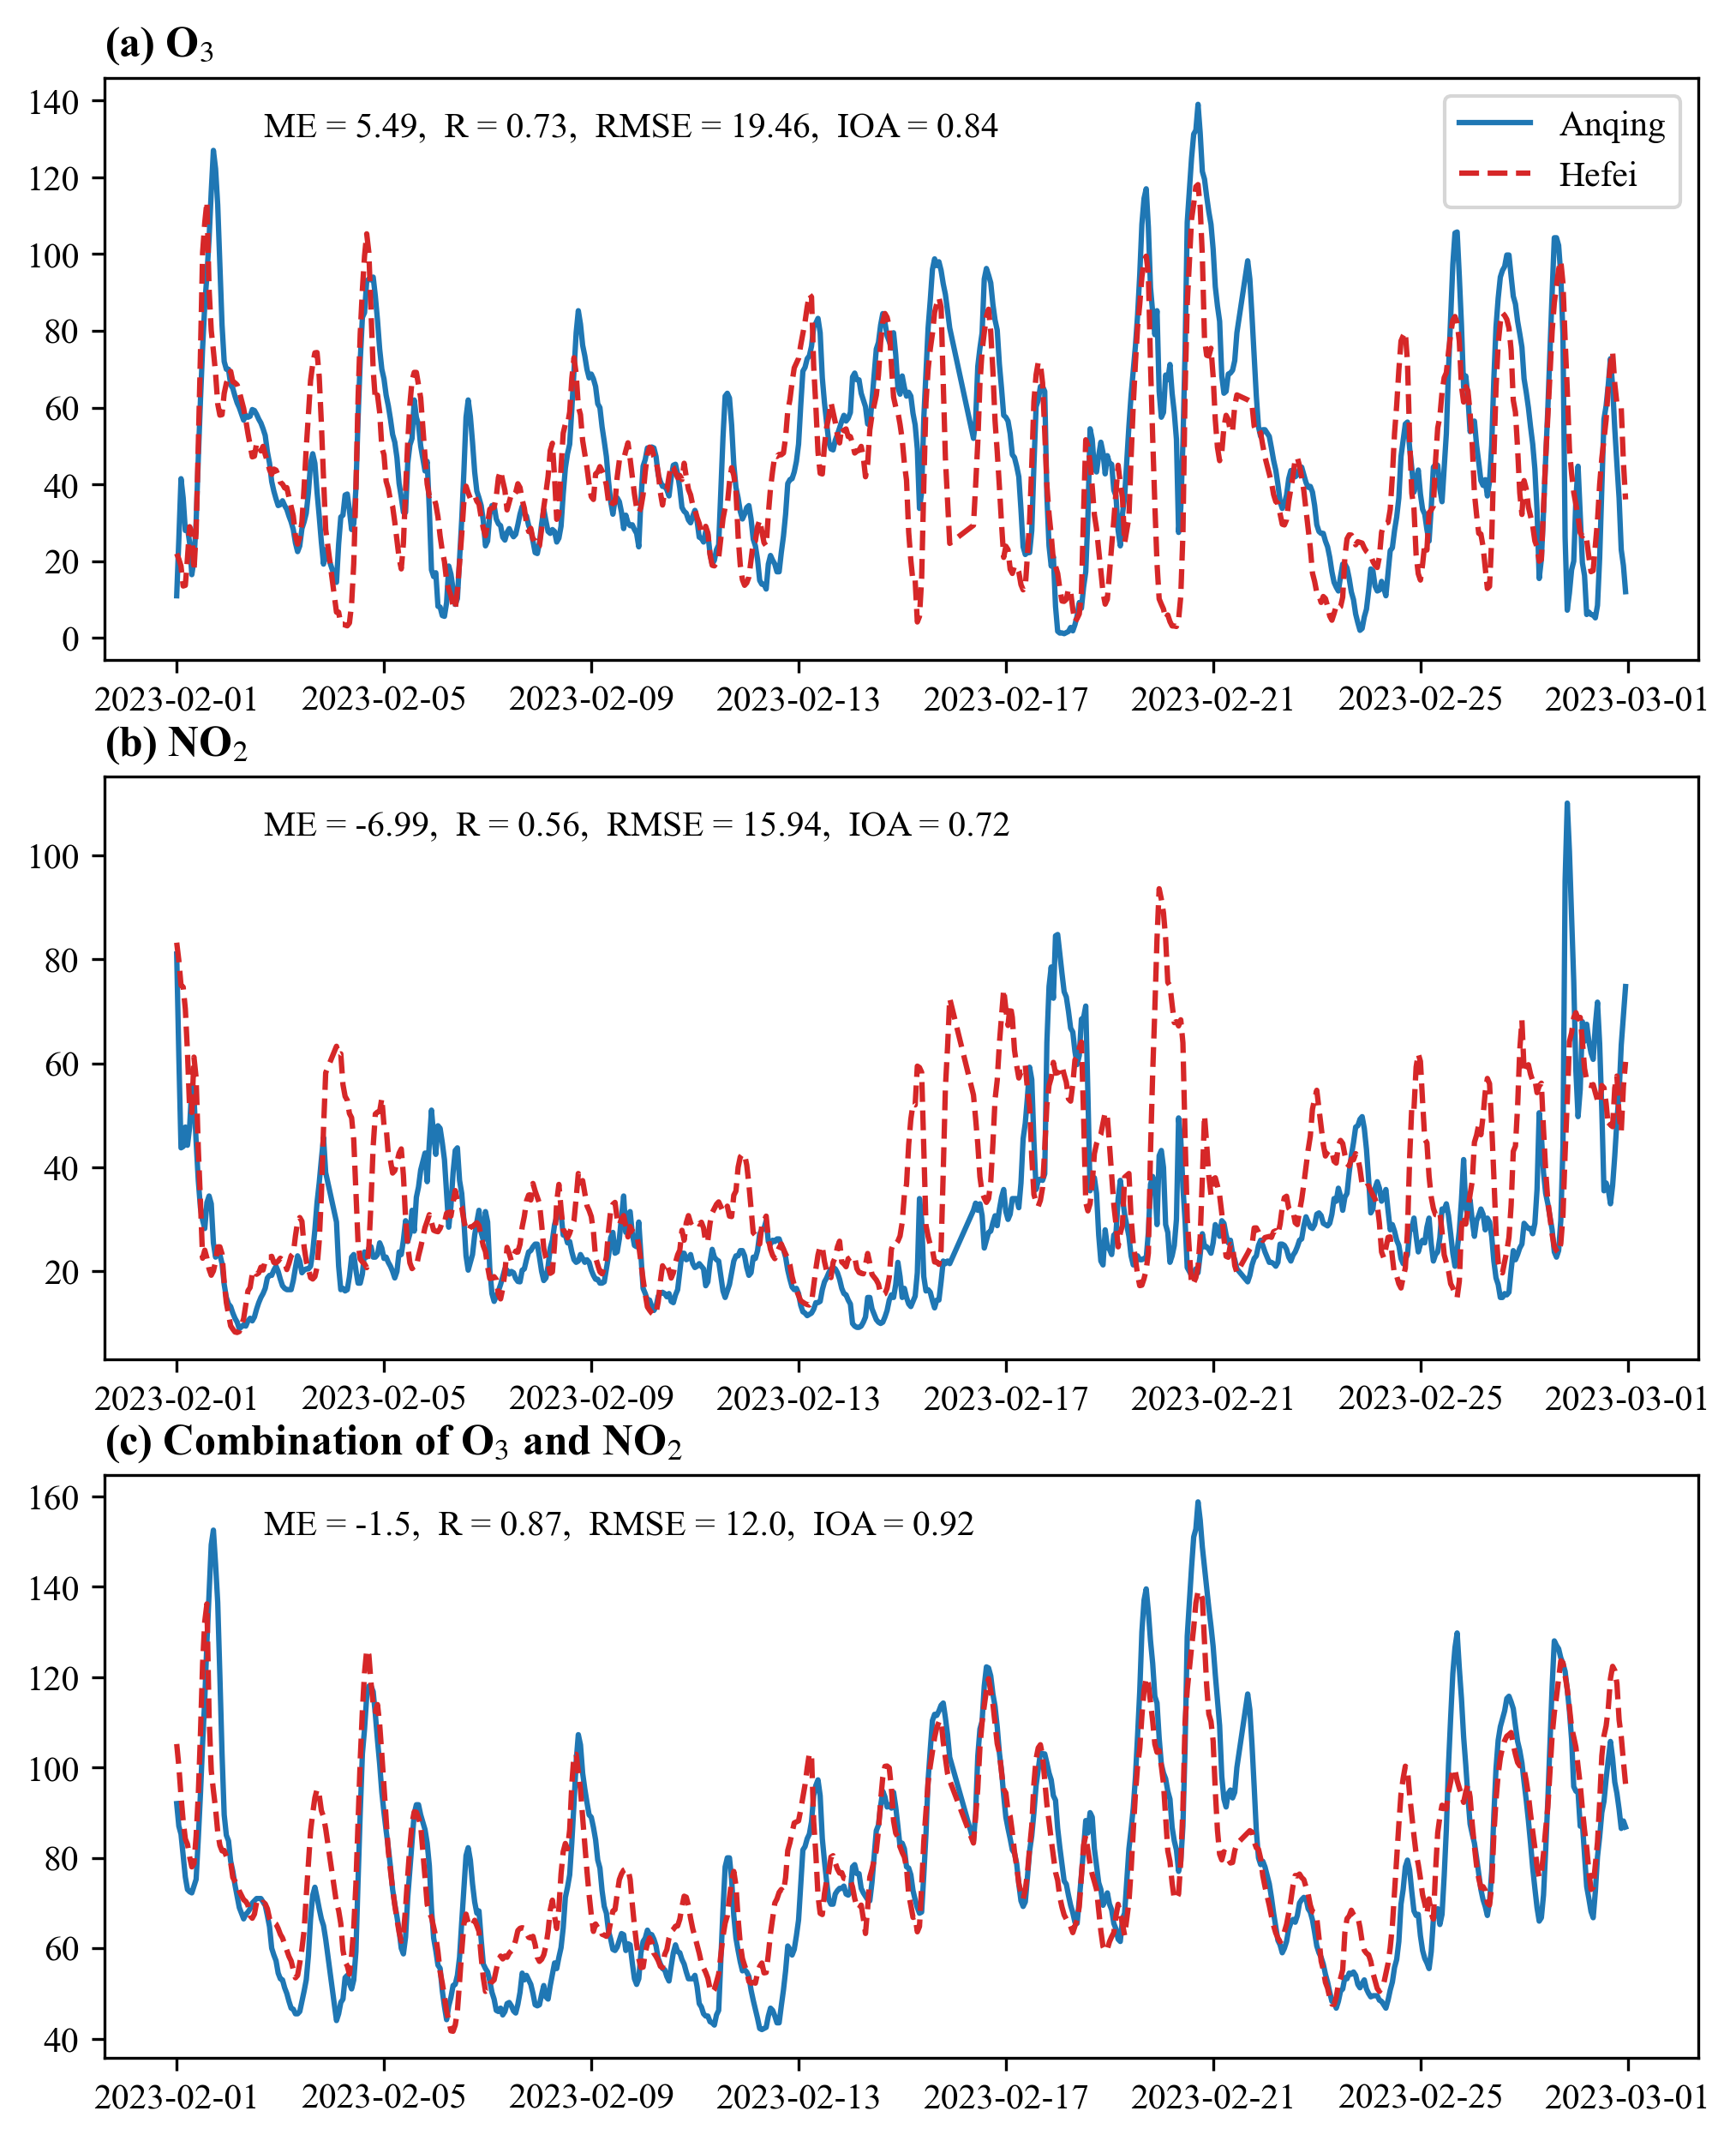

In [11]:
fig = plt.figure(figsize=(8,10),dpi=300)
ax  = fig.subplots(3,1)

time = pd.date_range('2023-02-01',periods=672,freq='H')

key_aq = {'linestyle':'-','label':'Anqing','color':'tab:blue'}
key_hf = {'linestyle':'--','label':'Hefei','color':'tab:red'}
ax[0].plot(time,obsO3_aq,**key_aq)
ax[0].plot(time,obsO3_hf,**key_hf)
evalstr = str('ME = '+str(me_O3['ME'].values[0])+',  '
              +'R = '+str(me_O3['R'].values[0])+',  '
              +'RMSE = '+str(me_O3['RMSE'].values[0])+',  '
              +'IOA = '+str(me_O3['IOA'].values[0]))
ax[0].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[0].transAxes)

ax[1].plot(time,obsNO2_aq,**key_aq)
ax[1].plot(time,obsNO2_hf,**key_hf)
evalstr = str('ME = '+str(me_NO2['ME'].values[0])+',  '
              +'R = '+str(me_NO2['R'].values[0])+',  '
              +'RMSE = '+str(me_NO2['RMSE'].values[0])+',  '
              +'IOA = '+str(me_NO2['IOA'].values[0]))
ax[1].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[1].transAxes)

ax[2].plot(time,obscom_aq,**key_aq)
ax[2].plot(time,obscom_hf,**key_hf)
evalstr = str('ME = '+str(me_com['ME'].values[0])+',  '
              +'R = '+str(me_com['R'].values[0])+',  '
              +'RMSE = '+str(me_com['RMSE'].values[0])+',  '
              +'IOA = '+str(me_com['IOA'].values[0]))
ax[2].text(x=0.1,y=0.9,s=evalstr,ha='left',transform=ax[2].transAxes)

ax[0].legend(loc=1)
ax[0].set_title('(a) O$_3$',loc='left',weight='bold')
ax[1].set_title('(b) NO$_2$',loc='left',weight='bold')
ax[2].set_title('(c) Combination of O$_3$ and NO$_2$',loc='left',weight='bold')

plt.show()


## 如果比较安庆的O3与合肥的NO2呢？

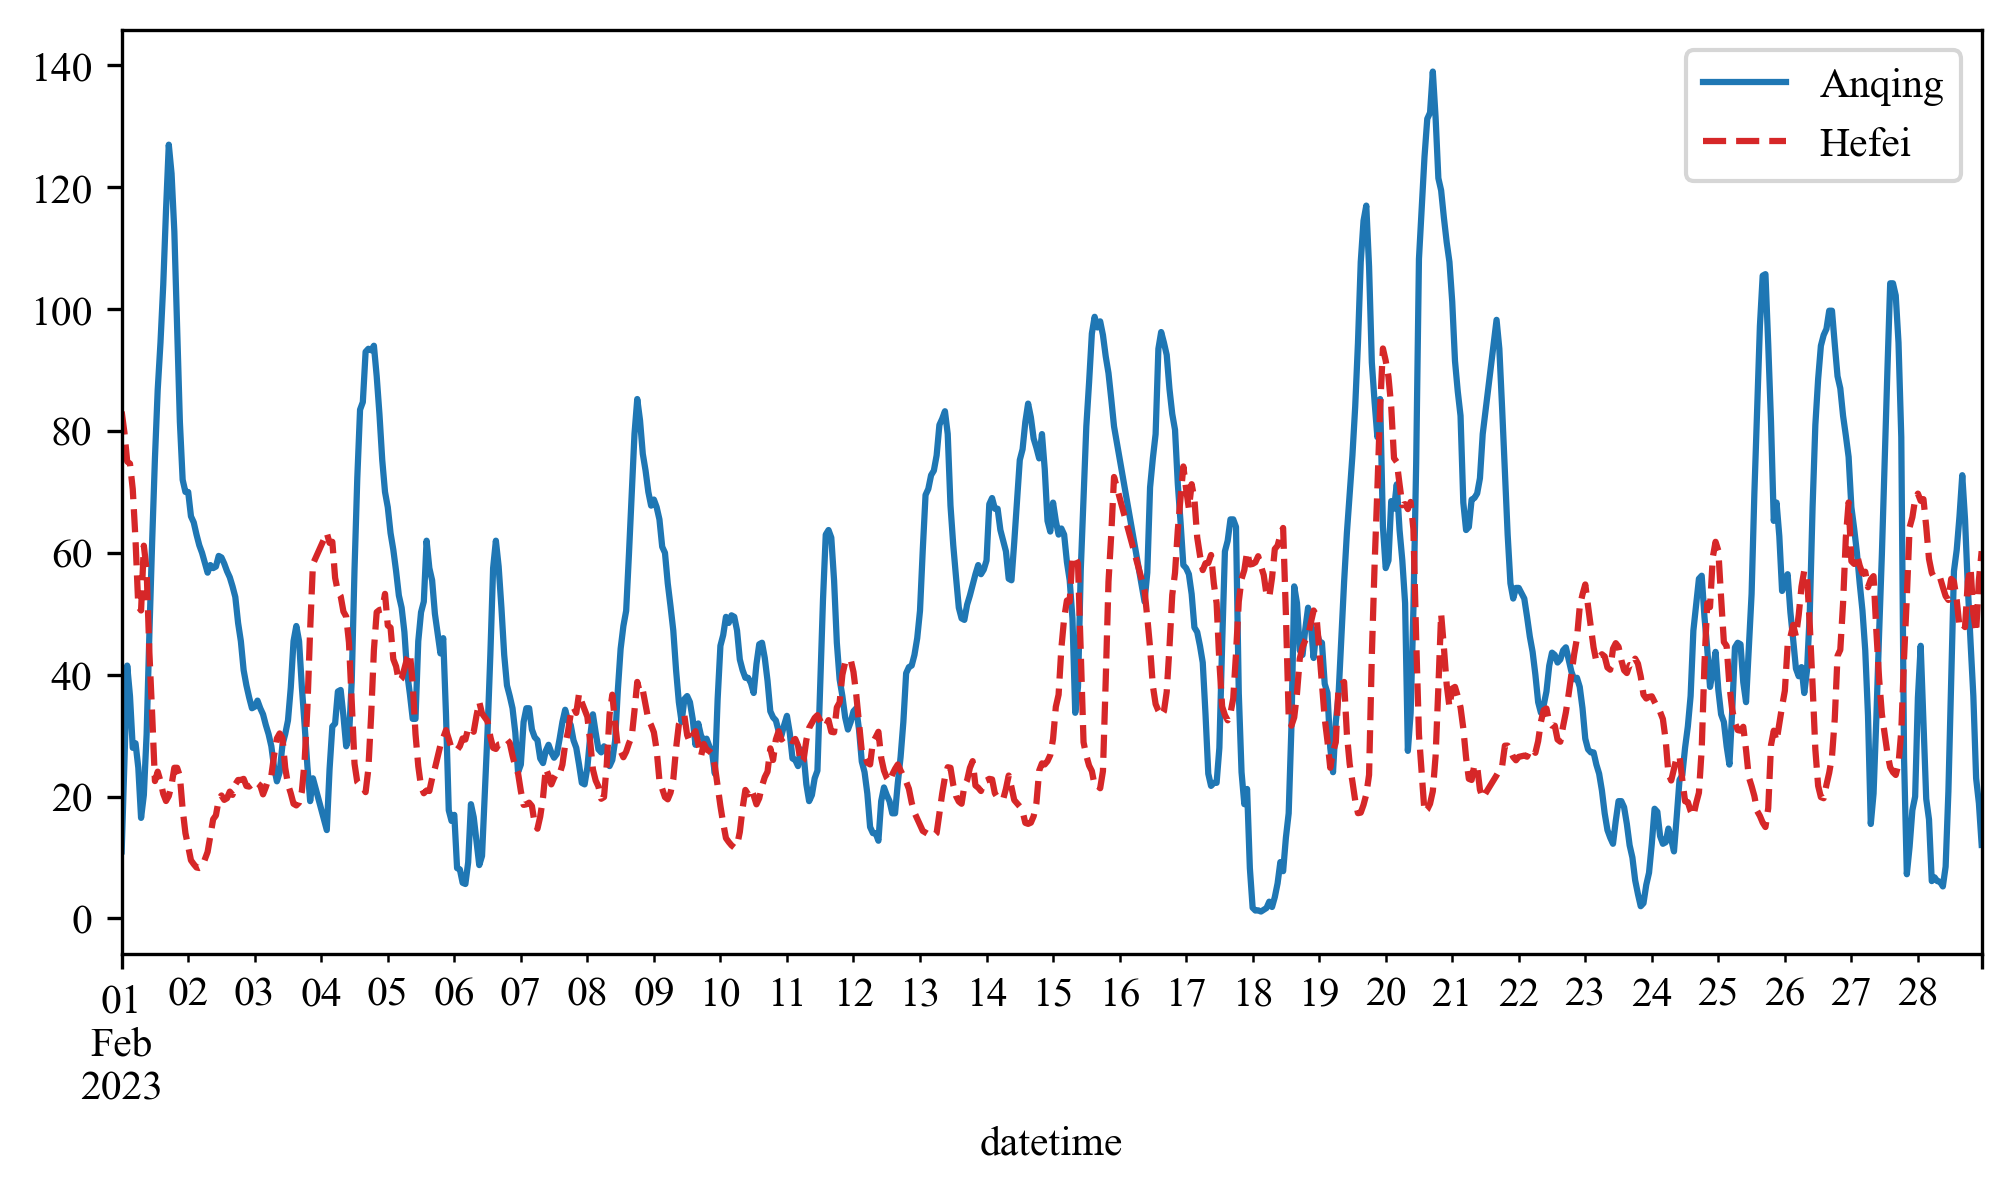

In [12]:
fig = plt.figure(figsize=(8,4),dpi=300)
ax  = fig.subplots(1,1)

obsO3_aq.plot(ax=ax,linestyle='-',label='Anqing',color='tab:blue')
obsNO2_hf.plot(ax=ax,linestyle='--',label='Hefei',color='tab:red')

ax.legend(loc=1)
# ax.set_title('Combination of O$_3$ and NO$_2$')

plt.show()
